$G_i + P \quad[k^{b_P}_i]<->[k^{u_P}_i] \quad  G_i:P \\
G_i:P \quad  --> [k_i^{tx}] \quad  G_i + P + T_i \\
T_i + R \quad  [k^{b_R}_i]<->[k^{u_R}_i]\quad   T_i:R \\
T_i:R  \quad -->[k_i^{tl}]\quad T_i + R + X_i \\
T_i + E \quad  [k^{b_E}_i]<->[k^{u_E}_i] \quad  T_i:E \\
T_i:E \quad-->[\delta_i]\quad E \\
T \quad-->[d_T]\quad \\
X \quad-->[d]\quad $

In [1]:
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from autoreduce import *
import numpy as np
from sympy import symbols

In [2]:
# Post conservation law and other approximations phenomenological model at the RNA level
n = 8 # Number of states : P, C1, T, R, C2, E, C3, X
nouts = 1 # Number of outputs, X_i

# Inputs by user 
x_init = np.zeros(n)
x_init[0] = 100
x_init[3] = 400
x_init[5] = 20
C = np.zeros((nouts,n), dtype=int)
C[0][7] = 1

nstates_tol_max = 3
nsatees_tol_min = 2
error_tol = 3000
# System dynamics symbolically

# k_bp, k_up, k_tx, k_br, k_ur, k_tl, k_be, k_ue, d_i, d = params, len(params) = 10


x0 = symbols('P')
x1 = symbols('C1') # G:P
x2 = symbols('T')
x3 = symbols('R')
x4 = symbols('C2') # T:R
x5 = symbols('E')
x6 = symbols('C3') # T:E
x7 = symbols('X')

x = [x0, x1, x2, x3, x4, x5, x6, x7]

G = symbols('G')
k_bp = symbols('k_bp')
k_up = symbols('k_up')
k_tx = symbols('k_tx')
k_br = symbols('k_br')
k_ur = symbols('k_ur')
k_tl = symbols('k_tl')
k_be = symbols('k_be')
k_ue = symbols('k_ue')
d_i = symbols('d_i')
d = symbols('d')
d_T = symbols('d_T')

E_tot = symbols('E_tot')
P_tot = symbols('P_tot')
R_tot = symbols('R_tot')
params = [k_bp, k_up, k_tx, k_br, k_ur, k_tl, k_be, k_ue, d_i, d, d_T, E_tot, P_tot, R_tot, G]
# f0 = (k_bp + k_tx) * x1 - k_up * G * x0
f0 = (k_up + k_tx) * x1 - k_bp * G * x0
f1 = k_bp * G * x0 - (k_up + k_tx)*x1
f2 = k_tx * x1 + (k_ur + k_tl) * x4 + k_ue * x6 - k_br * x2 * x3 - k_be * x2 * x5 - d_T * x2
f3 = (k_ur + k_tl) * x4 - k_br * x2 * x3
f4 = k_br * x2 * x3 - (k_ur + k_tl) * x4
f5 = (k_ue + d_i) * x6 - k_be * x2 * x5
f6 = k_be * x2 * x5 - (k_ue + d_i) * x6
f7 = k_tl * x4 - d * x7
    
f = [f0,f1,f2,f3,f4,f5,f6,f7]
# parameter values
# E_tot = 20
# P_tot = 100
# R_tot = 400
params_values = [30, 10, 0.50, 80, 2, 8, 10, 2, 1, 0.5, 0.01, 20, 100, 400, 10]
# params_values = [100, 10, 4, 10, 0.25, 2, 10, 0.5, 1, 1, 1000, 1000, 1000, 10]
sys = System(x, f, params = params, params_values = params_values, C = C, x_init = x_init)

Text(0.5, 0, 'Time')

Text(0, 0.5, '[Outputs]')

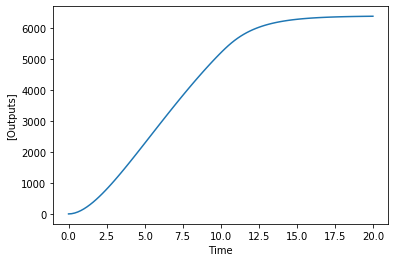

In [3]:
from autoreduce.utils import get_ODE
timepoints_ode = np.linspace(0, 20, 100)
sys_ode = get_ODE(sys, timepoints_ode)
sol = sys_ode.solve_system().T
import matplotlib.pyplot as plt
plt.plot(timepoints_ode, np.transpose(np.array(C)@sol))
plt.xlabel('Time')
plt.ylabel('[Outputs]')
plt.show()

In [4]:
from autoreduce.utils import get_reducible
timepoints_ssm = np.linspace(0,2,10)
timepoints_ode = np.linspace(0,2,100)
sys_reduce = get_reducible(sys, timepoints_ode, timepoints_ssm)
sys_reduce.nstates_tol_min = 2
sys_reduce.nstates_tol_max = 3

In [5]:
P, C1, T, R, C2, E, C3, X = sys.x
conserved_quantities = [P + C1 - P_tot, R + C2 - R_tot, E + C3 - E_tot]
states_to_eliminate = [C1, C2, C3]
f_cons = sys_reduce.set_conservation_laws(conserved_quantities, states_to_eliminate)

In [6]:
f_cons

[-G*P*k_bp + (-P + P_tot)*(k_tx + k_up),
 -E*T*k_be - R*T*k_br - T*d_T + k_tx*(-P + P_tot) + k_ue*(-E + E_tot) + (-R + R_tot)*(k_tl + k_ur),
 -R*T*k_br + (-R + R_tot)*(k_tl + k_ur),
 -E*T*k_be + (-E + E_tot)*(d_i + k_ue),
 -X*d + k_tl*(-R + R_tot)]

Text(0.5, 0, 'Time')

Text(0, 0.5, '[X]')

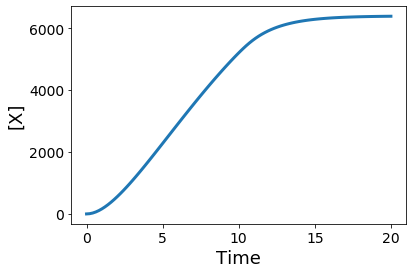

In [7]:
from autoreduce.utils import get_ODE
timepoints_ode = np.linspace(0, 20, 100)
# params = [k_bp, k_up, k_tx, k_br, k_ur, k_tl, k_be, k_ue, d_i, d, E_tot, P_tot, R_tot, G]
# params_values = [100, 10, 4, 10, 0.25, 2, 10, 0.5, 1, 10, 10000, 10000, 10000, 0.01]
# params_values = [30, 10, 0.50, 80, 2, 8, 10, 2, 1, 0.5, 0.01, 20, 100, 400, 10]
# sys_reduce.params_values = params_values
sys_ode = get_ODE(sys_reduce, timepoints_ode)
sol = sys_ode.solve_system().T
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
plt.plot(timepoints_ode, np.transpose(np.array(sys_reduce.C)@sol), linewidth = 3)
plt.xlabel('Time', FontSize = 18)
plt.ylabel('[X]', FontSize = 18)
ax.tick_params(axis='both', which='major', labelsize=14)
# plt.legend()
plt.show()

In [8]:
sys_reduce.f

[-G*P*k_bp + (-P + P_tot)*(k_tx + k_up),
 -E*T*k_be - R*T*k_br - T*d_T + k_tx*(-P + P_tot) + k_ue*(-E + E_tot) + (-R + R_tot)*(k_tl + k_ur),
 -R*T*k_br + (-R + R_tot)*(k_tl + k_ur),
 -E*T*k_be + (-E + E_tot)*(d_i + k_ue),
 -X*d + k_tl*(-R + R_tot)]

In [9]:
sys_reduce.x

[P, T, R, E, X]

In [10]:
reduced_sys, fast_ss = sys_reduce.solve_timescale_separation([T,X], fast_states = [E, R, P], debug = True)


Reduced set of variables is [T, X]
f_hat =  [-E*T*k_be - R*T*k_br - T*d_T + k_tx*(-P + P_tot) + k_ue*(-E + E_tot) + (-R + R_tot)*(k_tl + k_ur), -X*d + k_tl*(-R + R_tot)]
Collapsed set of variables is [E, R, P]
SAyush {}
In sympy_solve_and_substitute, solving for  E
From  -E*T*k_be + (-E + E_tot)*(d_i + k_ue)
Solution found:  {E: [E_tot*(d_i + k_ue)/(T*k_be + d_i + k_ue)]}
current state E
Updated f_hat now is  [-E_tot*T*k_be*(d_i + k_ue)/(T*k_be + d_i + k_ue) - R*T*k_br - T*d_T + k_tx*(-P + P_tot) + k_ue*(-E_tot*(d_i + k_ue)/(T*k_be + d_i + k_ue) + E_tot) + (-R + R_tot)*(k_tl + k_ur), -X*d + k_tl*(-R + R_tot)]
In sympy_solve_and_substitute, solving for  R
From  -R*T*k_br + (-R + R_tot)*(k_tl + k_ur)
Solution found:  {E: [E_tot*(d_i + k_ue)/(T*k_be + d_i + k_ue)], R: [R_tot*(k_tl + k_ur)/(T*k_br + k_tl + k_ur)]}
current state R
Updated f_hat now is  [-E_tot*T*k_be*(d_i + k_ue)/(T*k_be + d_i + k_ue) - R_tot*T*k_br*(k_tl + k_ur)/(T*k_br + k_tl + k_ur) - T*d_T + k_tx*(-P + P_tot) + k_ue*(-E

In [11]:
reduced_sys.f[1]

-X*d + k_tl*(-R_tot*(k_tl + k_ur)/(T*k_br + k_tl + k_ur) + R_tot)

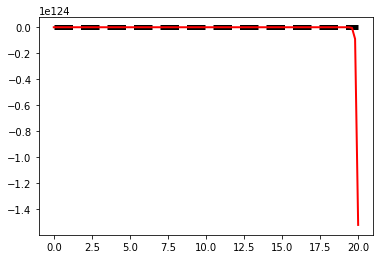

In [12]:
fig, ax = plt.subplots() 
# params = [k_bp, k_up, k_tx, k_br, k_ur, k_tl, k_be, k_ue, d_i, d, d_T, E_tot, P_tot, R_tot, G]
params_values_new = [80, 2, 0.5, 80, 2, 5, 80, 2, 0.1, 0.5, 0.05, 100, 100, 400, 10]
sys_reduce.params_values = params_values_new

sys_ode = get_ODE(sys_reduce, timepoints_ode)
sol = sys_ode.solve_system().T
_ = plt.plot(timepoints_ode, np.transpose(np.array(sys_reduce.C)@sol), 'k--', label = 'Full CRN model', linewidth = 5)
reduced_ode = get_ODE(reduced_sys, timepoints_ode)
reduced_sol = reduced_ode.solve_system().T
_ = plt.plot(timepoints_ode, np.transpose(np.array(reduced_sys.C)@reduced_sol), 'r', label = 'Reduced model', linewidth = 2)
plt.show()


In [13]:
sys_reduce.nstates_tol_min

2

In [12]:
results = sys_reduce.reduce_simple(skip_numerical_computations = True)
# reduced_sys, fast_ss = sys_reduce.solve_timescale_separation([T,X], debug = False)
# se1 = sys_reduce.get_robustness_metric(reduced_sys)
# e1 = sys_reduce.get_error_metric(reduced_sys)


SAyush {}
Solution found:  {T: [(-E*k_ue + E_tot*k_ue - P*k_tx + P_tot*k_tx - R*k_tl - R*k_ur + R_tot*k_tl + R_tot*k_ur)/(E*k_be + R*k_br + d_T)]}
current state T
Solution found:  {T: [(-E*k_ue + E_tot*k_ue - P*k_tx + P_tot*k_tx - R*k_tl - R*k_ur + R_tot*k_tl + R_tot*k_ur)/(E*k_be + R*k_br + d_T)], R: [R_tot*(k_tl + k_ur)*(E*k_be + d_T)/(E*k_be*k_tl + E*k_be*k_ur - E*k_br*k_ue + E_tot*k_br*k_ue - P*k_br*k_tx + P_tot*k_br*k_tx + d_T*k_tl + d_T*k_ur)]}
current state R
multiple solutions found!! E
Solution found:  {T: [(-E*k_ue + E_tot*k_ue - P*k_tx + P_tot*k_tx - R*k_tl - R*k_ur + R_tot*k_tl + R_tot*k_ur)/(E*k_be + R*k_br + d_T)], R: [R_tot*(k_tl + k_ur)*(E*k_be + d_T)/(E*k_be*k_tl + E*k_be*k_ur - E*k_br*k_ue + E_tot*k_br*k_ue - P*k_br*k_tx + P_tot*k_br*k_tx + d_T*k_tl + d_T*k_ur)], E: [(E_tot*d_i*k_be + P*k_be*k_tx - P_tot*k_be*k_tx - d_T*d_i - d_T*k_ue - sqrt(E_tot**2*d_i**2*k_be**2 + 2*E_tot*P*d_i*k_be**2*k_tx - 2*E_tot*P_tot*d_i*k_be**2*k_tx + 2*E_tot*d_T*d_i**2*k_be + 2*E_tot*d_T*d_

Successful time-scale separation solution obtained with states: [R, X]!
SAyush {}
Solution found:  {P: [P_tot*(k_tx + k_up)/(G*k_bp + k_tx + k_up)]}
current state P
Solution found:  {P: [P_tot*(k_tx + k_up)/(G*k_bp + k_tx + k_up)], T: [(-E*G*k_bp*k_ue - E*k_tx*k_ue - E*k_ue*k_up + E_tot*G*k_bp*k_ue + E_tot*k_tx*k_ue + E_tot*k_ue*k_up + G*P_tot*k_bp*k_tx - G*R*k_bp*k_tl - G*R*k_bp*k_ur + G*R_tot*k_bp*k_tl + G*R_tot*k_bp*k_ur - R*k_tl*k_tx - R*k_tl*k_up - R*k_tx*k_ur - R*k_up*k_ur + R_tot*k_tl*k_tx + R_tot*k_tl*k_up + R_tot*k_tx*k_ur + R_tot*k_up*k_ur)/(E*G*k_be*k_bp + E*k_be*k_tx + E*k_be*k_up + G*R*k_bp*k_br + G*d_T*k_bp + R*k_br*k_tx + R*k_br*k_up + d_T*k_tx + d_T*k_up)]}
current state T
Solution found:  {P: [P_tot*(k_tx + k_up)/(G*k_bp + k_tx + k_up)], T: [(-E*G*k_bp*k_ue - E*k_tx*k_ue - E*k_ue*k_up + E_tot*G*k_bp*k_ue + E_tot*k_tx*k_ue + E_tot*k_ue*k_up + G*P_tot*k_bp*k_tx - G*R*k_bp*k_tl - G*R*k_bp*k_ur + G*R_tot*k_bp*k_tl + G*R_tot*k_bp*k_ur - R*k_tl*k_tx - R*k_tl*k_up - R*k_tx*k_

Solution found:  {T: [(-E*k_ue + E_tot*k_ue - P*k_tx + P_tot*k_tx - R*k_tl - R*k_ur + R_tot*k_tl + R_tot*k_ur)/(E*k_be + R*k_br + d_T)], R: [R_tot*(k_tl + k_ur)*(E*k_be + d_T)/(E*k_be*k_tl + E*k_be*k_ur - E*k_br*k_ue + E_tot*k_br*k_ue - P*k_br*k_tx + P_tot*k_br*k_tx + d_T*k_tl + d_T*k_ur)]}
current state R
Shailja_Ayush {T: [(-E*k_ue + E_tot*k_ue - P*k_tx + P_tot*k_tx - R*k_tl - R*k_ur + R_tot*k_tl + R_tot*k_ur)/(E*k_be + R*k_br + d_T)], R: [R_tot*(k_tl + k_ur)*(E*k_be + d_T)/(E*k_be*k_tl + E*k_be*k_ur - E*k_br*k_ue + E_tot*k_br*k_ue - P*k_br*k_tx + P_tot*k_br*k_tx + d_T*k_tl + d_T*k_ur)]}
Successful time-scale separation solution obtained with states: [P, E, X]!
SAyush {}
Solution found:  {P: [P_tot*(k_tx + k_up)/(G*k_bp + k_tx + k_up)]}
current state P
Solution found:  {P: [P_tot*(k_tx + k_up)/(G*k_bp + k_tx + k_up)], E: [E_tot*(d_i + k_ue)/(T*k_be + d_i + k_ue)]}
current state E
Shailja_Ayush {P: [P_tot*(k_tx + k_up)/(G*k_bp + k_tx + k_up)], E: [E_tot*(d_i + k_ue)/(T*k_be + d_i + k_

In [12]:
list(results.keys())[1].x
# reduced_sys.f
# isinstance(reduced_sys, System)

[P, T, X]

In [12]:
reduced_states = [sys_x.x for sys_x in list(results.keys())]
reduced_states

[[T, X],
 [P, T, X],
 [T, R, X],
 [T, E, X],
 [R, E, X],
 [P, T, R, X],
 [P, T, E, X],
 [P, R, E, X],
 [T, R, E, X]]

In [13]:
reduced_sys, fast_ss = sys_reduce.solve_timescale_separation([R, X])
reduced_sys.f[1]
# from auto_reduce.utils import get_ODE
x_sol_hat = get_ODE(sys_reduce.get_system(), timepoints_ode).solve_system()

Successful time-scale separation solution obtained with states:! [T, R, X]


-R*T*k_br + (-R + R_tot)*(k_tl + k_ur)

### Write results into LaTeX

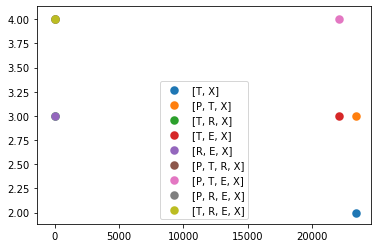

In [14]:
# results
import matplotlib.pyplot as plt
for key, value in results.items():
    plt.scatter(value[0], key.n,linewidths = 2.5, label = str(key.x))
plt.legend()
plt.savefig('enzymatic_rxn_e.svg')

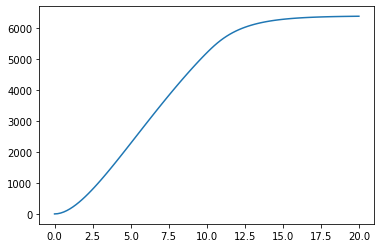

In [15]:
import matplotlib.pyplot as plt
y_hat = sys_reduce.C@x_sol_hat.T
plt.plot(timepoints_ode,y_hat.T)

In [17]:
from autoreduce.utils import reduce_utils
rx = reduce_utils(sys_reduce)
rx.write_results('gene_expression_results_with_input.txt')

In [18]:
from sympy.printing import latex
filename = 'gene_expression_results_with_input.txt'
f1 = open(filename, 'w')
f1.write('Model reduction results.\n')
for key,value in sys_reduce.results_dict.items():
#     f1.write('A possible reduced model: \n \n')
    f1.write('\n$x_{hat} = ')
    f1.write(str(key.x))
    f1.write('$\n\n\n\n')
    for k in range(len(key.f)):
        f1.write('\n$f_{hat}('+ str(k+1) + ') = ')
        f1.write(latex(key.f[k]))
        f1.write('$\n\n')
#     f1.write('\n\n\n')
#     f1.write('\nError metric:')
#     f1.write(str(value[0]))
#     f1.write('\n\n\n')
#     f1.write('\nRobustness metric:')
#     f1.write(str(value[1]))
#     f1.write('\n\n\n')
#     f1.write('Other properties') 
#     f1.write('\n\n\n')
#     f1.write('\n C = ')
#     f1.write(str(key.C))
#     f1.write('\n$ g = ')
#     f1.write(str(key.g))
#     f1.write('$\n h = ')
#     f1.write(str(key.h))
#     f1.write('\n$h = ')
#     f1.write(str(key.h))
#     f1.write('$\n Solutions : \n')
#     f1.write(str(key.x_sol))
#     f1.write('\n\n\n\n')
#     f1.write('\n Sensitivity Solutions : \n')
#     f1.write(str(key.S))
#     f1.write('\n\n\n\n')
f1.close()

25

12

6

5

15

511

3

15

111

3

12

9

5

15

70

3

15

441

3

15

111

3

12

9

5

15

371

3

15

70

3

15

41

3

12

9

5

15

375

3

15

69

3

15

111

3

12

9

5

15

299

3

15

298

3

15

41

3

12

12

5

15

70

3

15

301

3

15

70

3

15

41

3

12

12

5

15

70

3

15

305

3

15

69

3

15

111

3

12

12

5

15

70

3

15

229

3

15

228

3

15

41

3

12

12

5

15

235

3

15

70

3

15

69

3

15

41

3

### Error metric

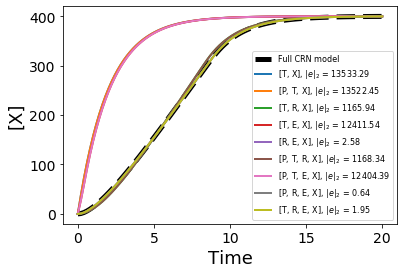

In [16]:
fig, ax = plt.subplots() 
count = 0
# params = [k_bp, k_up, k_tx, k_br, k_ur, k_tl, k_be, k_ue, d_i, d, d_T, E_tot, P_tot, R_tot, G]
params_values_new = [80, 2, 0.5, 80, 2, 0.5, 80, 2, 0.1, 0.5, 0.05, 40, 100, 400, 10]
sys_reduce.params_values = params_values_new

sys_ode = get_ODE(sys_reduce, timepoints_ode)
sol = sys_ode.solve_system().T
_ = plt.plot(timepoints_ode, np.transpose(np.array(sys_reduce.C)@sol), 'k--', label = 'Full CRN model', linewidth = 5)
for key,value in results.items():
    error = value[0]
#     if error > 1e-5:
    sys_i = key
    sys_i.params_values = params_values_new
#     if sys_i.x == [T,R,X] or sys_i.x == [R, E, X] or sys_i.x == [T,X]:
#         _ = plt.subplots(count%3, count%3)
    sys_i_ode = get_ODE(sys_i, timepoints_ode)
    sol_i = sys_i_ode.solve_system().T
    _ = plt.plot(timepoints_ode, np.transpose(sys_i.C@sol_i), label = str(sys_i.x)+', $\|e\|_2$ = '+str("%.2f" %error), linewidth = 2)
    _ = plt.xlabel('Time', FontSize = 18)
    _ = plt.ylabel('[X]', FontSize = 18)
    _ = ax.tick_params(axis='both', which='major', labelsize=14)
    _ = plt.legend(prop={'size': 8})
    count += 1

# _ = plt.axvline(x=timepoints_ode[6], color = 'k',linestyle = ':',linewidth = 1.5)
# _ = plt.axvline(x=timepoints_ode[15], color = 'k',linestyle = ':',linewidth = 1.5)
# _ = plt.axvline(x=timepoints_ode[30], color = 'k',linestyle = ':',linewidth = 1.5)
_ = plt.savefig('error_metric_gene_expression.svg')
plt.show()


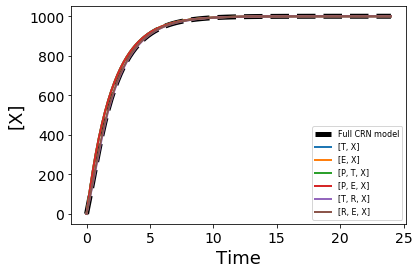

In [93]:
fig, ax = plt.subplots() 
count = 0
# params = [k_bp, k_up, k_tx, k_br, k_ur, k_tl, k_be, k_ue, d_i, d, d_T, E_tot, P_tot, R_tot, G]
params_values_new = [80, 2, 0.5, 80, 2, 0.5, 20, 5, 0.1, 0.5, 0.05, 100, 1000, 1000, 0.1]
sys_reduce.params_values = params_values_new
timepoints_ode = np.linspace(0,24,100)
sys_ode = get_ODE(sys_reduce, timepoints_ode)
sol = sys_ode.solve_system().T
_ = plt.plot(timepoints_ode, np.transpose(np.array(sys_reduce.C)@sol), 'k--', label = 'Full CRN model', linewidth = 5)
for key,value in results.items():
#     error = value[0]
#     if error > 1e-5:
    sys_i = key
    sys_i.params_values = params_values_new
    if sys_i.x == [T,E,X] or sys_i.x == [P, R, X] or sys_i.x == [R,X] or sys_i.x == [P, X] or len(sys_i.x) >= 4:
        continue
#         _ = plt.subplots(count%3, count%3)
    sys_i_ode = get_ODE(sys_i, timepoints_ode)
    sol_i = sys_i_ode.solve_system().T
    _ = plt.plot(timepoints_ode, np.transpose(sys_i.C@sol_i), label = str(sys_i.x), linewidth = 2)
    _ = plt.xlabel('Time', FontSize = 18)
    _ = plt.ylabel('[X]', FontSize = 18)
    _ = ax.tick_params(axis='both', which='major', labelsize=14)
    _ = plt.legend(prop={'size': 8})
    count += 1

# _ = plt.axvline(x=timepoints_ode[6], color = 'k',linestyle = ':',linewidth = 1.5)
# _ = plt.axvline(x=timepoints_ode[15], color = 'k',linestyle = ':',linewidth = 1.5)
# _ = plt.axvline(x=timepoints_ode[30], color = 'k',linestyle = ':',linewidth = 1.5)
_ = plt.savefig('error_metric_gene_expression.svg')
plt.show()


### Robustness metric 


In [ ]:
# fig, ax = plt.subplots() 
fig = plt.figure(num=None, figsize=(7, 6), dpi=80, facecolor='w', edgecolor='k')
# count = 0
import seaborn as sn
# params_names = ['$'+str(i)+'$' for i in params]
params_names = ['$k_{bp}$', '$k_{up}$', '$k_{tx}$', '$k_{br}$', '$k_{ur}$', '$k_{tl}$', '$k_{be}$', '$k_{ue}$',
          '$d_i$', '$d$', '$E_{tot}$', '$P_{tot}$', '$R_{tot}$']
rob_2d_all = []
rob_2d = []
sys_reduced_x = []
# plt.plot(timepoints_ode, np.transpose(np.array(sys_reduce.C)@sol), 'k--', label = 'Full CRN model', linewidth = 5)
# params_names[0] = '$k_b$'
for key,value in results.items():
    sys_i = key
    Se = value[1]
    Se = np.delete(Se, -1)
    if len(sys_i.x) > 4:
        continue
    sys_reduced_x.append(str(sys_i.x))
    rob_2d.append(Se)

sn_ax = sn.heatmap(np.array(rob_2d), cbar_kws={'label': 'Robustness metric ($\|S_e\|$)', 'orientation':'horizontal','fraction':0.2})
# cbar_axes = sn_ax.figure.axes[-1]
sn_ax.figure.axes[-1].xaxis.label.set_size(18)
ax = fig.axes
_ = plt.xlabel('Parameters', FontSize = 18)
_ = plt.ylabel('Reduced models', FontSize = 18)
_ = ax[0].tick_params(axis='x', which='major', labelsize=14)
_ = ax[0].set_xticklabels(params_names)
_ = ax[0].set_yticklabels(sys_reduced_x, rotation = 0)
# h.set_rotation(0)
_ = plt.savefig('robustness_metric_gene_expression_final.svg')
plt.show()

### Gamma (Input-Output mapping) => linearize the dynamics

In [ ]:
t_lin = [timepoints_ode[6], timepoints_ode[15], timepoints_ode[30]]
fig = plt.figure()
from auto_reduce.utils import get_SSM
from scipy import signal
from scipy.linalg import solve_lyapunov
G_2norms = {}
list_of_systems = [i for i in results.keys()]
list_of_systems.append(sys_reduce)
for sys_i in list_of_systems:
    if len(sys_i.x) > 3 and sys_i is not sys_reduce:
        continue
    sys_i_ode = get_ODE(sys_i, timepoints_ode)
    sol_i = sys_i_ode.solve_system().T
    for t in t_lin:
        x_pt = sol_i[:,list(timepoints_ode).index(t)]
        A_i = compute_J(sys_i, x_pt, mode = 'accurate')
        sys_i_ssm = get_SSM(sys_i, timepoints_ode)
        B_i = sys_i_ssm.compute_Zj(x_pt, 13)
        B_i = np.reshape(B_i, (len(sys_i.x),1))
        n_size = np.shape(J_i)[1]
        C_i = sys_i.C
        G_i = signal.StateSpace(A_i, B_i, C_i, 0)
        G_i_tf = signal.TransferFunction(G_i)
        L = solve_lyapunov(A_i, -B_i@B_i.T)
        val_2norm = np.sqrt(C_i@L@C_i.T)
        G_2norms[str(sys_i.x) + ' at time ' + str(t)] = val_2norm
    if sys_i == sys_reduce:
        _ = plt.plot(timepoints_ode, np.transpose(sys_i.C@sol_i), 'k--', label = str('Full CRN model') +', $\gamma(H)$ = '+str("%.2f" %val_2norm), linewidth = 5)
    else:
        _ = plt.plot(timepoints_ode, np.transpose(sys_i.C@sol_i), label = str(sys_i.x)+', $\gamma(H)$ = '+str("%.2f" %val_2norm), linewidth = 2)
    _ = plt.xlabel('Time', FontSize = 18)
    _ = plt.ylabel('[X]', FontSize = 18)

ax = fig.axes[0]
_ = ax.tick_params(axis='both', which='major', labelsize=14)
_ = plt.legend(prop={'size': 8})
_ = plt.axvline(x=timepoints_ode[6], color = 'k',linestyle = ':',linewidth = 1.5)
_ = plt.axvline(x=timepoints_ode[15], color = 'k',linestyle = ':',linewidth = 1.5)
_ = plt.axvline(x=timepoints_ode[30], color = 'k',linestyle = ':',linewidth = 1.5)
_ = plt.savefig('gene_expression_gamma.svg')
plt.show()


In [ ]:
from scipy.linalg import eigvals, norm
# eigvals(J_i)
# len(params)
# A_i
G_2norms
# C_i


In [ ]:
sys_reduce.x

In [ ]:
sys_reduce.get_error_metric(list(results.keys())[-3])
sys_i = list(results.keys())[-3]
sys_i_ode = get_ODE(sys_i, timepoints_ode)
sol_i = sys_i_ode.solve_system().T
sys_ode = get_ODE(sys_reduce, timepoints_ode)
sol = sys_ode.solve_system().T
plt.plot(timepoints_ode, np.transpose(np.array(sys_reduce.C)@sol))
plt.plot(timepoints_ode, np.transpose(np.array(sys_i.C)@sol_i))
plt.xlabel('Time')
plt.ylabel('[X]')
plt.show()
sys_i.x

In [ ]:
# params = [k_bp, k_up, k_tx, k_br, k_ur, k_tl, k_be, k_ue, d_i, d, E_tot, P_tot, R_tot]

params_values_new = params_values = params_values = [100, 10, 4, 10, 0.25, 2, 10, 0.5, 1, 10, 10000, 10000, 10000, 0.01]
sys.params_values = params_values_new
sys_gtx.params_values = params_values_new
sys_gc1tx.params_values = params_values_new
sys_gc2tx.params_values = params_values_new
sys_gc3tx.params_values = params_values_new
timepoints_ode = np.linspace(0, 5, 100)

sys_ode = get_ODE(sys_reduce, timepoints_ode)
sol = sys_ode.solve_system().T


sys_gtx_ode = get_ODE(sys_gtx, timepoints_ode)
x_gtx = sys_gtx_ode.solve_system().T


sys_gc1tx_ode = get_ODE(sys_gc1tx, timepoints_ode)
x_gc1tx = sys_gc1tx_ode.solve_system().T


sys_gc2tx_ode = get_ODE(sys_gc2tx, timepoints_ode)
x_gc2tx = sys_gc2tx_ode.solve_system().T


sys_gc3tx_ode = get_ODE(sys_gc3tx, timepoints_ode)
x_gc3tx = sys_gc3tx_ode.solve_system().T


In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
xs1 = list(results.keys())[3].x_sol
sys1 = list(results.keys())[3]
xs2 = list(results.keys())[6].x_sol
sys2 = list(results.keys())[6]
xs3 = list(results.keys())[8].x_sol
sys3 = list(results.keys())[8]
xs4 = list(results.keys())[10].x_sol
sys4 = list(results.keys())[10]
xs5 = list(results.keys())[11].x_sol
sys5 = list(results.keys())[11]
xs6 = list(results.keys())[13].x_sol
sys6 = list(results.keys())[13]
xs7 = list(results.keys())[14].x_sol
sys7 = list(results.keys())[14]
plt.plot(timepoints_ode, np.transpose(np.array(sys_reduce.C)@sol), 'k--', label = 'Full CRN model', linewidth = 5)
plt.plot(timepoints_ode, np.transpose(np.array(sys3.C)@xs3), label = str(sys1.x), linewidth = 2)
# plt.plot(timepoints_ode, np.transpose(np.array(sys_gc1tx.C)@x_gc1tx), label = str(sys_gc1tx.x), linewidth = 2)
# plt.plot(timepoints_ode, np.transpose(np.array(sys_gc2tx.C)@x_gc2tx), label = str(sys_gc2tx.x), linewidth = 2)
# plt.plot(timepoints_ode, np.transpose(np.array(sys_gc3tx.C)@x_gc3tx), label = str(sys_gc3tx.x), linewidth = 2)
plt.xlabel('Time', FontSize = 18)
plt.ylabel('[X]', FontSize = 18)
ax.tick_params(axis='both', which='major', labelsize=14)
plt.legend()
plt.savefig('gene_expression_timecourse.svg')
plt.show()

In [ ]:
sys_gc2tx.f[2]

In [ ]:
def evaluate(system, f, x, P, u = None):
    """
    Evaluate the given symbolic function (f) that is part of the System
    at the values given by x for self.x and P for self.params
    """
    fs = []
    for i in range(len(f)):
        fi = f[i]
        fi = fi.subs(list(zip(system.x, x)))
        if system.u is not None:
            fi = fi.subs(list(zip(system.u, u)))
        fi = fi.subs(list(zip(system.params, P)))
        fs.append(fi)
    return fs

def compute_J(system, x, **kwargs):
    '''
    Compute the Jacobian J = df/dx at a timepoint k.
    Returns a matrix of size n x n.
    Use mode = 'accurate' for this object attribute to use accurate computations using numdifftools.
    '''
    
    # initialize J
    J = np.zeros( (system.n, system.n) )   
    P = system.params_values 
    u = system.u
    # store x
    X = x 
    if 'fun' in kwargs:
        fun = kwargs.get('fun')
    else:
        fun = system.f
    for i in range(system.n):
        for j in range(system.n):
            F = np.zeros( (4,1) )
            h = X[j]*0.01
            # Gets O(4) central difference on dfi/dxj
            if h != 0:
                x = X
                x[j] = X[j] + 2*h
                f = evaluate(system, fun, x, P, u)
                F[0] = f[i]
                x[j] = X[j] + h
                f = evaluate(system, fun, x, P, u)
                F[1] = f[i]
                x[j] = X[j] - h
                f = evaluate(system, fun, x, P, u)
                F[2] = f[i]
                x[j] = X[j] - 2*h
                f = evaluate(system, fun, x, P, u)
                F[3] = f[i]
                #Store approx. dfi/dxj into J
                J[i,j]= (-F[0] + 8*F[1] - 8*F[2] + F[3])/(12*h)   
                # print(J[i,j])
                # if J[i,j] == np.Inf:
                #     J[i,j] = 1
                # elif J[i,j] == np.NaN:
                #     J[i,j] = 0
    return J


In [ ]:
t_lin = [timepoints_ode[6], timepoints_ode[15], timepoints_ode[30]]
# t_lin = [timepoints_ode[6]]
fig, ax = plt.subplots()
out_sol = np.array(sys_reduce.C)@sol
out_gtx = np.array(sys_gtx.C)@x_gtx
out_gc1tx = np.array(sys_gc1tx.C)@x_gc1tx
out_gc2tx = np.array(sys_gc2tx.C)@x_gc2tx
out_gc3tx = np.array(sys_gc3tx.C)@x_gc3tx
plt.plot(timepoints_ode, np.transpose(out_sol), 'k--', label = 'Full CRN model', linewidth = 5)
plt.plot(timepoints_ode, np.transpose(out_gtx), label = '[T, X]', linewidth = 2)
plt.plot(timepoints_ode, np.transpose(out_gc1tx), label = '[T, C1, X]', linewidth = 2)
plt.plot(timepoints_ode, np.transpose(out_gc2tx), label = '[T, C2, X]', linewidth = 2)
plt.plot(timepoints_ode, np.transpose(out_gc3tx), label = '[T, C3, X]', linewidth = 2)

for t in t_lin:
    x_pt = sol[:,list(timepoints_ode).index(t)]
    J_full = compute_J(sys_reduce, x_pt, mode = 'accurate')
#     B_full = compute_J(sys_reduce, x_pt, var = sys_reduce.g)
    n_size = np.shape(J_full)[1]
#     A_full = J_full[1:n_size,1:n_size]
#     B_full = J_full[0,:]
    C_full = sys_reduce.C
#     G_full = 
    
    x_pt = x_gtx[:,list(timepoints_ode).index(t)]
    J_gtx = compute_J(sys_gtx, x_pt, mode = 'accurate')
    n_size = np.shape(J_gtx)[1]
#     A_gtx = J_gtx[1:n_size,1:n_size]
#     B_gtx = J_gtx[0,:]
#     B_gtx = compute_J(sys_gtx, x_pt, var = sys_gtx.g)
    C_gtx = sys_gtx.C
    
    x_pt = x_gc1tx[:,list(timepoints_ode).index(t)]
    x_pt_C1 = x_pt
    J_gc1tx = compute_J(sys_gc1tx, x_pt, mode = 'accurate')
    n_size = np.shape(J_gc1tx)[1]
#     B_gc1tx = compute_J(sys_gc1tx, x_pt, var = sys_gc1tx.g)
#     A_gc1tx = J_gc1tx[1:n_size,1:n_size]
#     B_gc1tx = J_gc1tx[0,:]
    C_gc1tx = sys_gc1tx.C
    
    x_pt = x_gc2tx[:,list(timepoints_ode).index(t)]
    J_gc2tx = compute_J(sys_gc2tx, x_pt, mode = 'accurate')
    n_size = np.shape(J_gc2tx)[1]
#     B_gc2tx = compute_J(sys_gc2tx, x_pt, var = sys_gc2tx.g)
#     A_gc2tx = J_gc2tx[1:n_size,1:n_size]
#     B_gc2tx = J_gc2tx[0,:]
    C_gc2tx = sys_gc2tx.C
    
    x_pt = x_gc3tx[:,list(timepoints_ode).index(t)]
    J_gc3tx = compute_J(sys_gc3tx, x_pt, mode = 'accurate')
    n_size = np.shape(J_gc3tx)[1]
#     B_gc3tx = compute_J(sys_gc3tx, x_pt, var = sys_gc3tx.g)
#     A_gc3tx = J_gc3tx[1:n_size,1:n_size]
#     B_gc3tx = J_gc3tx[0,:]
    C_gc3tx = sys_gc3tx.C
    
    plt.axvline(x=t, color = 'k',linestyle = ':',linewidth = 1.5)
plt.xlabel('Time', FontSize = 18)
plt.ylabel('[X]', FontSize = 18)
ax.tick_params(axis='both', which='major', labelsize=14)
plt.legend()
plt.savefig('linearizations_model.svg')
plt.show()    

In [ ]:
x_pt_C1

In [ ]:
from scipy.linalg import eigvals
eigvals(A_full)

In [ ]:
np.shape(sys_reduce.x)

In [ ]:
arrr = np.zeros( (5,5) )

In [ ]:
arrr[2:-1,:]

In [ ]:
out_sol[:,list(timepoints_ode).index(t)]

In [ ]:
J_full[1:6,1:6]
# A_full

In [ ]:
J_full

In [ ]:
# At t = 0.1
norm_full = 0.04
norm_gtx = 5.4555e-13
norm_gc1tx = 0.04
norm_gc2tx = 0
norm_gc3tx = 2.7277e-13

# At t = 0.4
norm_full = 0.04
norm_gtx = 3.3490e-13
norm_c1gtx = 0.04
norm_c2gtx = 1.1543e-11
norm_c3gtx = 5.0234e-13


# At t = 1
norm_full = 0.0400
norm_gtx =  2.8312e-13
norm_c1gtx = 0.0400
norm_c2gtx = 5.8298e-13
norm_c3gtx =  5.6624e-13


In [ ]:
sys_gc1tx.f[0]

In [ ]:
sys_gc1tx.f[1]

In [ ]:
sys_gc1tx.f[2]

In [ ]:

sys_gc1tx.f[3]

In [ ]:
sys_gc1tx.x

In [ ]:
sys.f[0]

In [ ]:
A_gc1tx

In [ ]:
B_gc1tx